<a href="https://colab.research.google.com/github/Hyeeun98/kaggle_competition/blob/main/airbnb_new_user_bookings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이터 불러오기 

In [ ]:
!pip install kaggle --upgrade

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = 'hyeyoo'
os.environ['KAGGLE_KEY'] = '2f07fbc1e1299092a94ce3a59c547201'

In [ ]:
!kaggle -h

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions        Commands related to Kaggle competitions
    datasets            Commands related to Kaggle datasets
    kernels             Commands related to Kaggle kernels
    config              Configuration settings


In [ ]:
!kaggle competitions download -c airbnb-recruiting-new-user-bookings

sessions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_NDF.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_users_2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
countries.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_users.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
age_gender_bkts.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip '*zip'

Archive:  sample_submission_NDF.csv.zip
replace sample_submission_NDF.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! ls

age_gender_bkts.csv.zip  sample_submission_NDF.csv.zip	train_users_2.csv.zip
countries.csv.zip	 sessions.csv.zip
sample_data		 test_users.csv.zip


#Airbnb new user bookings

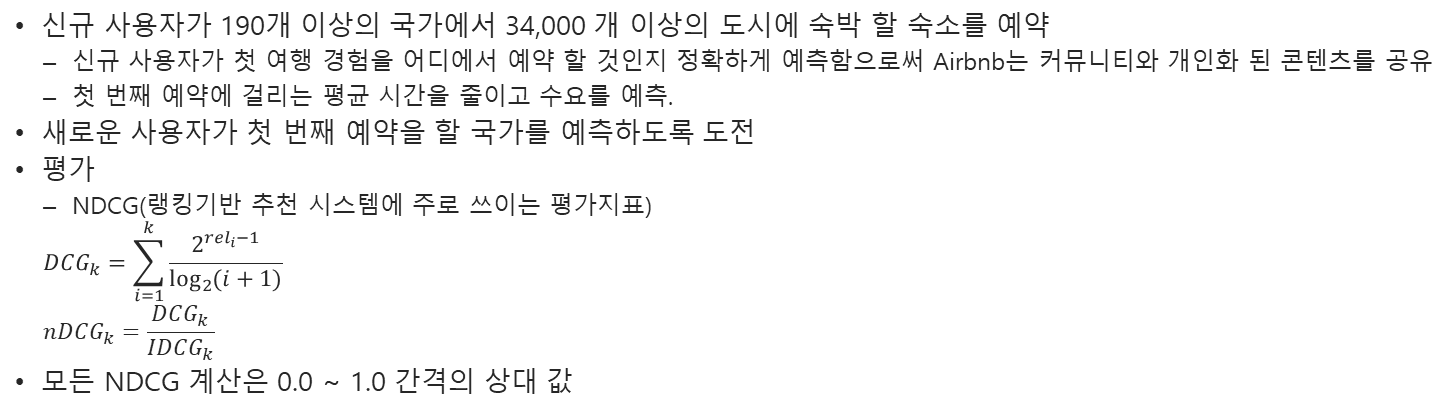

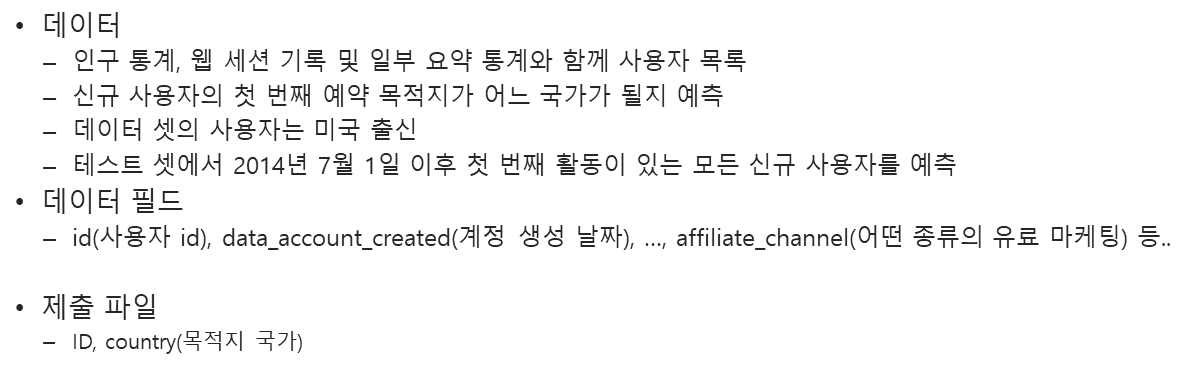

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#add colores for plot bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']     

In [ ]:
age_gender = pd.read_csv('age_gender_bkts.csv')
country = pd.read_csv('countries.csv')
session = pd.read_csv('sessions.csv')
test = pd.read_csv('test_users.csv',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
train = pd.read_csv('train_users_2.csv',parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])

a = pd.read_csv('sample_submission_NDF.csv')

In [ ]:
country.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [ ]:
country.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [ ]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [ ]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01 00:00:06,NaT,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,2014-07-01 00:00:51,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,2014-07-01 00:01:48,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,2014-07-01 00:02:15,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,2014-07-01 00:03:05,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [ ]:
a.head()

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF


시각화

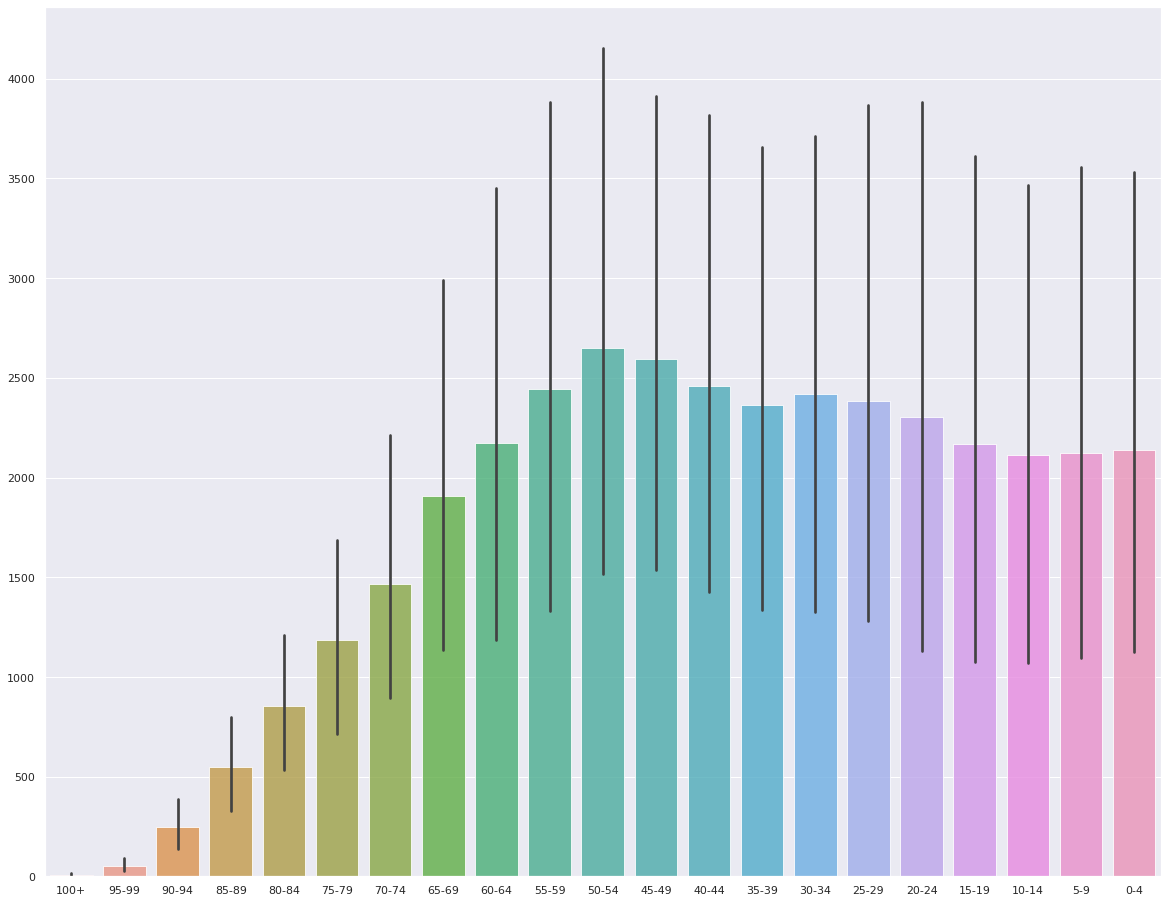

In [ ]:
plt.rcParams['figure.figsize'] = [20,16]
sns.barplot(list(age_gender['age_bucket']),list(age_gender['population_in_thousands']),alpha = 0.8)

### country 
1) us 에서 물리적 거리별로 나열

2) us 에서 언어적 거리별로 나열

In [ ]:
country.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [ ]:
country['country_destination'].unique() #10개 국가

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NL', 'PT', 'US'],
      dtype=object)

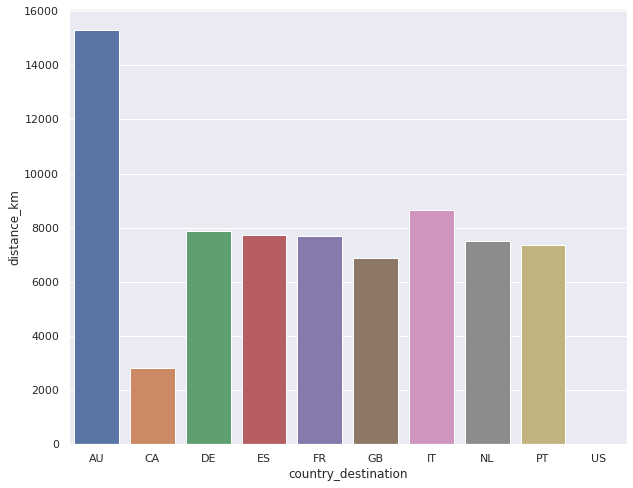

In [ ]:
plt.rcParams['figure.figsize'] = [10,8]
sns.barplot(country['country_destination'], country['distance_km']) #물리적 거리

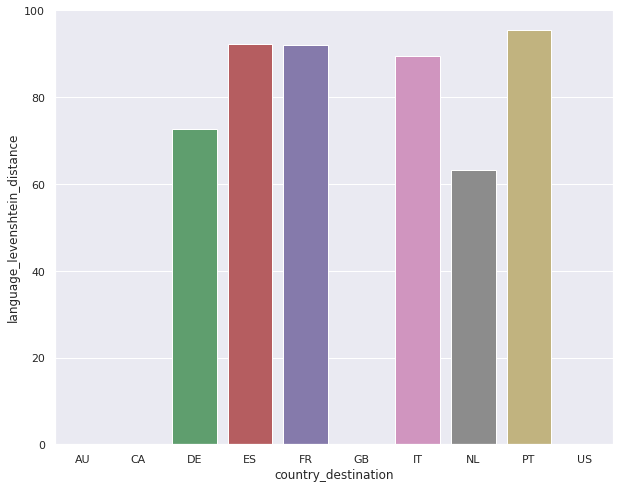

In [ ]:
sns.barplot(country['country_destination'], country['language_levenshtein_distance']) #언어적 거리

###session

In [ ]:
session.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [ ]:
len(session['user_id'].unique())

135484

In [ ]:
# user별로 탐색한 횟수의 평균 : [평균적으로 1] [최대 221] [최소 1] 

## 각 이용자별 웹이용횟수 중 50이상인 경우의 수 : [결과 1]
'''count = 0

if (len(session.value_counts()) >= 50):
  count+=1

print(count)''' 

session.value_counts()
#session.value_counts().mean()



#EDA _train&test concat

In [ ]:
train_test_combin = pd.concat((train, test), axis = 0, ignore_index = True)

In [ ]:
train_test_combin['age'].isnull.sum()

In [ ]:
train_test_combin.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
train_test_combin.shape

(275547, 16)

In [ ]:
train_test_combin.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         186639
gender                          0
age                        116866
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6085
signup_app                      0
first_device_type               0
first_browser                   0
country_destination         62096
dtype: int64

In [ ]:
print(train_test_combin.date_account_created.min())
print(train_test_combin.date_account_created.max())

2010-01-01 00:00:00
2014-09-30 00:00:00


In [ ]:
train_test_combin['signup_method'].value_counts()

basic       198222
facebook     74864
google        2438
weibo           23
Name: signup_method, dtype: int64

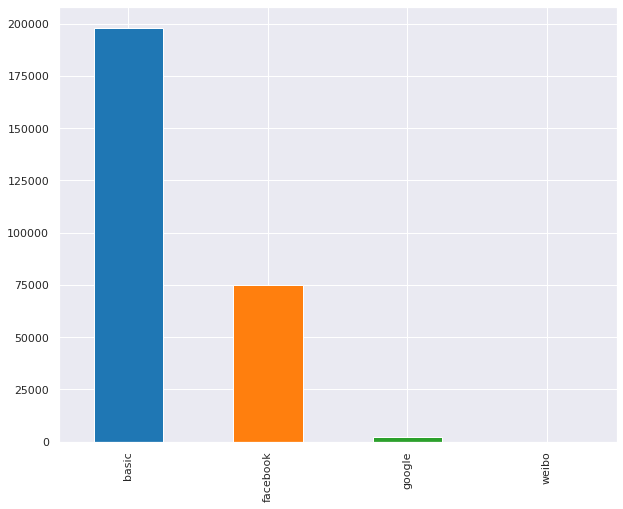

In [ ]:
train_test_combin.signup_method.value_counts(dropna=False).plot(kind='bar', color=colors)

In [ ]:
train_test_combin['first_device_type'].value_counts()

Mac Desktop           106328
Windows Desktop        86948
iPhone                 39814
iPad                   18036
Other/Unknown          11167
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
SmartPhone (Other)       191
Name: first_device_type, dtype: int64

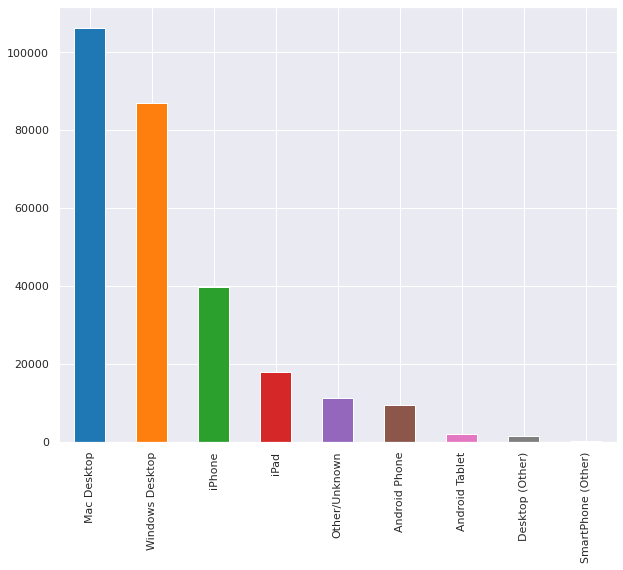

In [ ]:
train_test_combin.first_device_type.value_counts(dropna=False).plot(kind='bar', color=colors)

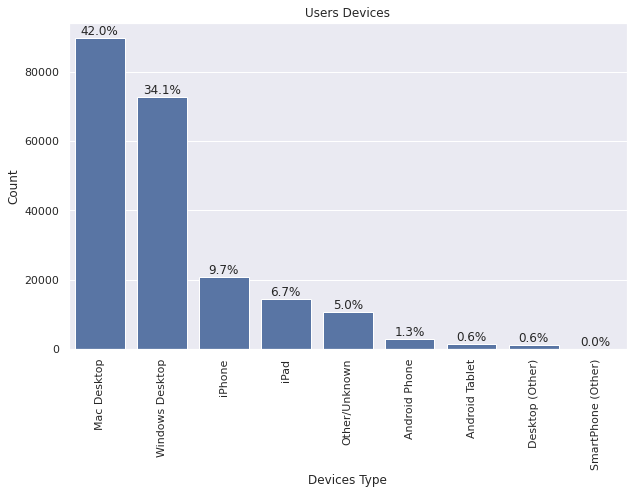

In [ ]:
plt.figure(figsize=(10,6))
cd_count_idx = train['first_device_type'].value_counts().index
sns.countplot(data = train, x = 'first_device_type', order = cd_count_idx, color = sns.color_palette()[0])
plt.xlabel('Devices Type')
plt.ylabel('Count')
plt.title('Users Devices')
plt.xticks(rotation=90)
cd_count_val = train['first_device_type'].value_counts()

for i in range(cd_count_val.shape[0]):
    count = cd_count_val[i]
    percentage ='{:0.1f}%'.format(100 * count / len(train))
    plt.text(i, count+1000, percentage, ha='center')

In [ ]:
train_test_combin['first_browser'].value_counts()

Chrome                  78671
Safari                  53302
-unknown-               44394
Firefox                 38665
Mobile Safari           29636
IE                      24744
Chrome Mobile            3186
Android Browser          1577
AOL Explorer              254
Opera                     228
Silk                      172
IE Mobile                 118
BlackBerry Browser         89
Chromium                   83
Mobile Firefox             64
Maxthon                    60
Apple Mail                 45
Sogou Explorer             43
SiteKiosk                  27
RockMelt                   24
Iron                       24
Yandex.Browser             14
IceWeasel                  14
Pale Moon                  13
SeaMonkey                  12
CometBird                  12
Camino                      9
TenFourFox                  8
Opera Mini                  8
wOSBrowser                  7
CoolNovo                    6
Avant Browser               4
Opera Mobile                4
Mozilla   

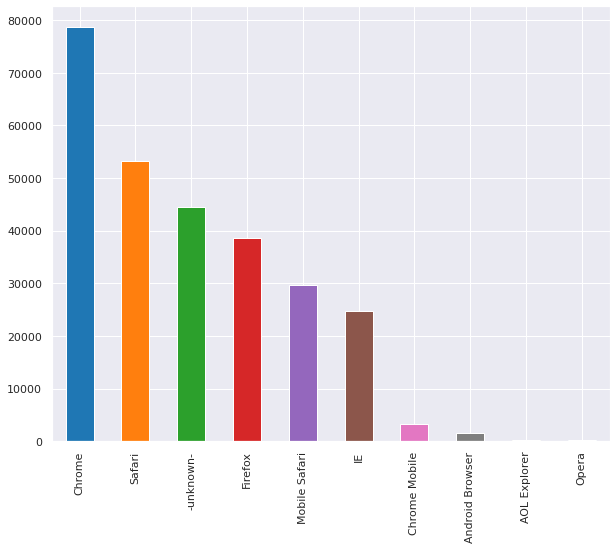

In [ ]:
train_test_combin['first_browser'].value_counts().head(10).plot(kind='bar', color=colors)

In [ ]:
train_test_combin['gender'].value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

In [ ]:
train_test_combin.groupby('gender').age.agg(['min','max','mean','count']) ##age의 max가 2014???

,min,max,mean,count
gender,,,,
-unknown-,1.0,2014.0,44.581328,22237
FEMALE,1.0,2014.0,49.645347,71907
MALE,1.0,2014.0,45.191540,64258
OTHER,17.0,2014.0,57.146953,279


In [ ]:
train_test_combin.loc[train_test_combin.age > 100, 'age'] = np.nan

In [ ]:
train_test_combin.groupby('gender').age.agg(['min','max','mean','count'])

,min,max,mean,count
gender,,,,
-unknown-,1.0,100.0,36.470110,21412
FEMALE,1.0,100.0,35.711567,70838
MALE,1.0,100.0,36.269660,63465
OTHER,17.0,78.0,35.876812,276


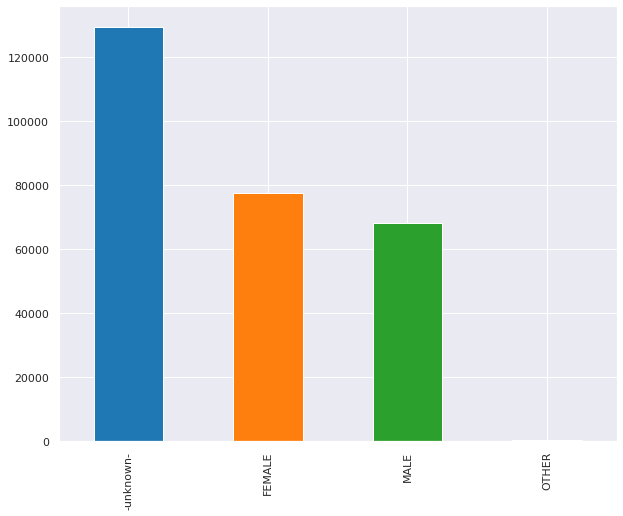

In [ ]:
train_test_combin['gender'].value_counts().plot(kind='bar', color=colors)

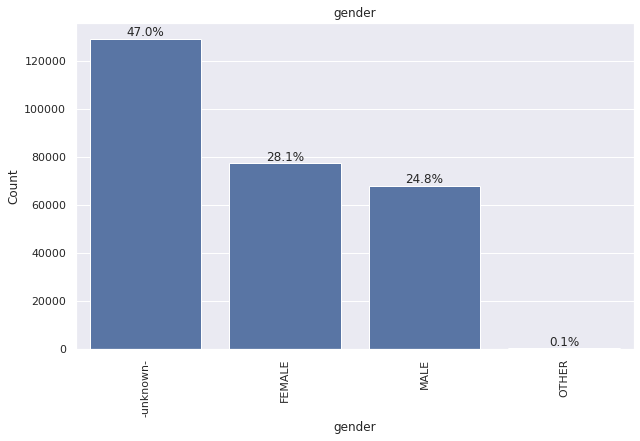

In [ ]:
plt.figure(figsize=(10,6))
cd_count_idx = train_test_combin['gender'].value_counts().index
sns.countplot(data = train_test_combin, x = 'gender', order = cd_count_idx, color = sns.color_palette()[0])
plt.xlabel('gender')
plt.ylabel('Count')
plt.title('gender')
plt.xticks(rotation=90)

cd_count_val = train_test_combin['gender'].value_counts()

for i in range(cd_count_val.shape[0]):
    count = cd_count_val[i]
    percentage ='{:0.1f}%'.format(100 * count / len(train_test_combin))
    plt.text(i, count+1000, percentage, ha='center')

In [ ]:
train_test_combin.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
#timestamp_first_active

# Splitting date into Day-Month-Year
# account created
train_test_combin['dac_year'] = train_test_combin.date_account_created.dt.year
train_test_combin['dac_month'] = train_test_combin.date_account_created.dt.month
train_test_combin['dac_day'] = train_test_combin.date_account_created.dt.day

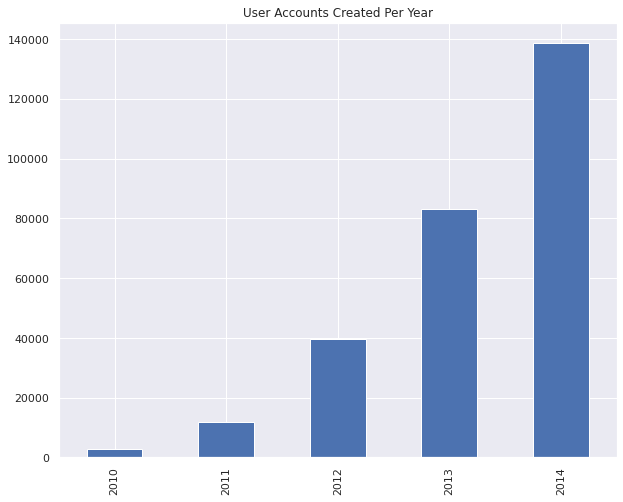

In [ ]:
train_test_combin.dac_year.value_counts(sort=False).plot(kind='bar', title='User Accounts Created Per Year')

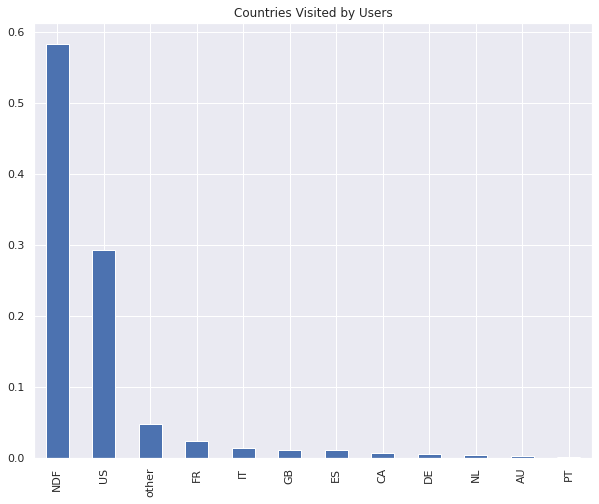

In [ ]:
train_test_combin.country_destination.value_counts(normalize=True).plot(kind='bar',title='Countries Visited by Users')

In [ ]:
X_train_data = train.drop(['id','date_account_created','date_first_booking','timestamp_first_active', 'country_destination'], axis=1)
X_test_data = test.drop(['id','date_account_created','date_first_booking','timestamp_first_active'], axis=1)
train_test_combin = train_test_combin.drop(['id', 'date_account_created','date_first_booking','timestamp_first_active','country_destination'], axis=1)

In [ ]:
# Replace unknown with NAN to avoid error 
train_test_combin.gender.replace('-unknown-', np.nan, inplace=True)
train_test_combin.first_browser.replace('-unknown-', np.nan, inplace=True)

In [ ]:
# Create Fetures categorical columns 

features = ['gender', 'signup_method', 'signup_flow', 'language',
                'affiliate_channel', 'affiliate_provider',
                'first_affiliate_tracked', 'signup_app',
                'first_device_type', 'first_browser']

# Get Dummies Convert categorical variable into dummy/indicator variables.

train_test_combin = pd.get_dummies(train_test_combin,columns=features)

In [ ]:
train_test_combin.head()

,age,dac_year,dac_month,dac_day,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_14,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,...,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IBrowse,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Nintendo Browser,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,NaN,2010,6,28,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,2011,5,25,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,56.0,2010,9,28,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,42.0,2011,12,5,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,41.0,2010,9,14,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# model

1, xgboost

In [ ]:
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
train_df_rows_no = train.shape[0]  

# Splitting the data into train and test again for the classifier
# rows number of train data will be used for splitting

# convert train_test_combin dataset into list
all_data_list = train_test_combin.values
X_train = all_data_list[:train_df_rows_no] # 213451
X_test = all_data_list[train_df_rows_no:] # 213451

#Create labels
#labels = train_df['country_destination'].values
labler = LabelEncoder()
y = labler.fit_transform(train['country_destination'].values)

# Implementation of the classifier (decision tree)
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=22,
                    objective='multi:softprob', subsample=0.6, colsample_bytree=0.6, seed=0)               
xgb.fit(X_train, y)
y_pred = xgb.predict_proba(X_test) 

In [ ]:
#Taking the 5 classes with highest probabilities
# the requirements is to predict 5 predicts for each ID (user)
# so we will predict 5 times and save the result for each user 

test_ids = test['id']
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_ids)):
    idx = test_ids[i]
    ids += [idx] * 5
    #save 5 results for each user 
    cts += labler.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

#Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('submission.csv',index=False)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head(10)

,id,country
0,5uwns89zht,NDF
1,5uwns89zht,US
2,5uwns89zht,other
3,5uwns89zht,FR
4,5uwns89zht,ES
5,jtl0dijy2j,NDF
6,jtl0dijy2j,US
7,jtl0dijy2j,other
8,jtl0dijy2j,FR
9,jtl0dijy2j,GB


3. tensorflow
https://www.kaggle.com/ma7555/in-depth-analysis-and-a-keras-dense-model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [ ]:
# check for different columns between train/test datasets
print(np.setdiff1d(train.columns, test.columns, assume_unique=True))

['country_destination']


In [ ]:
# Resplitting into train/test and calculating accuracy for random guess
new_train = df.iloc[:len(train)]
new_test = df.iloc[len(new_train):]
print('If you randomly guess using the same distribution, you should have an accuracy around {}%'.format(round(target_labels.value_counts(normalize=True).nlargest(1).values[0]*100, 2)))

NameError: ignored

In [ ]:
nclasses = len(np.unique(target_labels))
nfeatures = np.size(new_train, axis=1)

target_labels_keras = to_categorical(target_labels)

# keras model
model = Sequential()
model.add(Dense(nfeatures, activation='elu', kernel_initializer='he_normal', input_shape=(nfeatures,)))
model.add(Dense(150, activation='elu', kernel_initializer='he_normal'))
model.add(Dense(100, activation='elu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='elu', kernel_initializer='he_normal'))
model.add(Dense(20, activation='elu', kernel_initializer='he_normal'))
model.add(Dense(15, activation='elu', kernel_initializer='he_normal'))
model.add(Dense(nclasses, activation='softmax', kernel_initializer='he_normal'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fit model
model.fit(new_train, target_labels_keras, validation_split=0.15, epochs=15)

2. nDCG
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/discussion/17624

In [ ]:

# import required package
from sklearn.metrics import ndcg_score, dcg_score
import numpy as np
  
# Relevance scores in Ideal order
true_relevance = np.asarray([[3, 2, 1, 0, 0]])
  
# Relevance scores in output order
relevance_score = np.asarray([[3, 2, 0, 0, 1]])
  
# DCG score
dcg = dcg_score(true_relevance, relevance_score)
print("DCG score : ", dcg)
  
# IDCG score
idcg = dcg_score(true_relevance, true_relevance)
print("IDCG score : ", idcg)
  
# Normalized DCG score
ndcg = dcg / idcg
print("nDCG score : ", ndcg)
  
# or we can use the scikit-learn ndcg_score package
print("nDCG score (from function) : ", ndcg_score(
    true_relevance, relevance_score))